In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
year_start = 1998
year_end = 2018
years_iter = range(year_start,year_end)

# Read cleaned data

- ## MSA data

In [52]:
df = {}
for year in years_iter:
    df[year] = pd.read_csv('data/cleaned/msa_naicssector_cleanedv2_totEmploy_'+str(year)+'.csv')
    
# used later to rank the MSA's by employment
df_2017 = df[2017].copy()

- ## State-country data

In [53]:
df_state = {}
for year in years_iter:
    df_state[year] = pd.read_csv('data/cleaned/state_naicssector_cleanedv2_totEmploy_'+str(year)+'.csv')

# Merge data

- ## MSA

In [54]:
for year in years_iter:
    df[year] = df[year].set_index(['MSA','NAICS Code'],drop=True)
    
tot_empl_all = df[year_start]
for year in range(year_start+1,year_end):
    tot_empl_all = pd.merge(tot_empl_all, df[year],how='inner' ,on=['MSA','NAICS Code'],copy=False )
    #df_all.to_csv('data/draft/df_all_merge_'+str(year)+'.csv')
    
tot_empl_all = tot_empl_all.T
tot_empl_all.index = list(years_iter)

- ## state-country

In [55]:
for year in years_iter:
    df_state[year] = df_state[year].set_index(['State','NAICS Code'],drop=True)

tot_empl_state_all = df_state[year_start]
for year in range(year_start+1,year_end):
    tot_empl_state_all = pd.merge(tot_empl_state_all, df_state[year],how='inner' ,on=['State','NAICS Code'],copy=False )
    
tot_empl_state_all = tot_empl_state_all.T
tot_empl_state_all.index = list(years_iter)

# Calculate PPC: point percent change

- ## MSA

In [146]:
window_size = 2

#tot_empl_ppc = tot_empl_all.diff()/tot_empl_all.shift()*100
tot_empl_ppc = tot_empl_all.pct_change().drop( tot_empl_all.index[0] )*100
tot_empl_ppc.loc[2003] = (tot_empl_ppc.loc[2002]+tot_empl_ppc.loc[2004])/2
tot_empl_ppc = tot_empl_ppc.rolling(window=window_size,center=False).mean().drop( tot_empl_ppc.index[:window_size-1] )

- ## State-Country

In [148]:
#tot_empl_state_ppc = tot_empl_state_all.diff().dropna()/tot_empl_state_all.shift().dropna()*100
tot_empl_state_ppc = tot_empl_state_all.pct_change().drop( tot_empl_state_all.index[0] )*100
tot_empl_state_ppc.loc[2003] = (tot_empl_state_ppc.loc[2002]+tot_empl_state_ppc.loc[2004])/2
tot_empl_state_ppc = tot_empl_state_ppc.rolling(window=window_size,center=False).mean().drop( tot_empl_state_ppc.index[:window_size-1] )

# Utilities

- ## MSA to State 

In [29]:
MSA_df = pd.read_csv('data/MSA_wikipedia.csv',delimiter='\t')

MSAs = MSA_df['Metropolitan statistical area ']
MSA_shorts = MSAs.map(lambda x: x.split(',')[0].split('-')[0].lower() )
MSA_shorts_dict = {MSA_shorts.iloc[i]:
                   {'MSA': MSAs.iloc[i][:-1],
                    'State': MSAs.iloc[i].split(', ')[1].split(' ')[0] } for i in range(len(MSAs))  }


state_abbr_df = pd.read_csv('data/state_abbr.csv',delimiter='\t',names=['State','Abbr.'])
state_to_abbr_dict = { state_abbr_df['State'].iloc[i].title()[0:-1] :state_abbr_df['Abbr.'].iloc[i] for i in range(len(state_abbr_df)) }
state_to_abbr_dict['United States'] = 'US'

abbr_to_state_dict ={ v:k for k,v in state_to_abbr_dict.items()}

MSA_to_state_dict = { MSAs.iloc[i][:-1]: MSAs.iloc[i].split(', ')[1].split(' ')[0]  for i in range(len(MSAs))  }

- ## Compare MSA data to state and country data

In [30]:
def ppc_relative( MSA,NAICS_code ):
    return (tot_empl_ppc[ (MSA,NAICS_code) ]-tot_empl_state_ppc[ ( abbr_to_state_dict[MSA_to_state_dict[MSA]] ,NAICS_code) ],
            tot_empl_ppc[ (MSA,NAICS_code) ]-tot_empl_state_ppc[ ( 'United States' ,NAICS_code) ] )

- ## NAICS Codes

In [31]:
NAICS_df = pd.read_csv('data/NAICS_codes.csv',delimiter='    ')
NAICS_dict = { NAICS_df['NAICS Code'].iloc[i]:NAICS_df['Description'].iloc[i] for i in NAICS_df.index }
NAICS_dict['--'] = 'Total'
NAICS_dict

<ipython-input-31-48819ea87482>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  NAICS_df = pd.read_csv('data/NAICS_codes.csv',delimiter='    ')


{'11': 'Agriculture, Forestry, Fishing and Hunting',
 '21': 'Mining, Quarrying, and Oil and Gas Extraction',
 '22': 'Utilities',
 '23': 'Construction',
 '31-33': 'Manufacturing',
 '42': 'Wholesale Trade',
 '44-45': 'Retail Trade',
 '48-49': 'Transportation and Warehousing',
 '51': 'Information',
 '52': 'Finance and Insurance',
 '53': 'Real Estate and Rental and Leasing',
 '54': 'Professional, Scientific, and Technical Services',
 '55': 'Management of Companies and Enterprises',
 '56': 'Administrative and Support and Waste Management and Remediation Services',
 '61': 'Educational Services',
 '62': 'Health Care and Social Assistance',
 '71': 'Arts, Entertainment, and Recreation',
 '72': 'Accommodation and Food Services',
 '81': 'Other Services (except Public Administration)',
 '92': 'Public Administration',
 '99': 'Unclassified',
 '--': 'Total'}

- ## MSA rank by total Employment

In [32]:
msa_emp_rank_df =  df_2017[ df_2017['NAICS Code']=='--' ].sort_values(by='Total Employment - 2017',ascending=False).reset_index(drop=True)
del msa_emp_rank_df['NAICS Code'], msa_emp_rank_df['Total Employment - 2017']
msa_emp_rank_df_dict = {i:msa_emp_rank_df['MSA'].iloc[i] for i in range(len(msa_emp_rank_df))  }

- ## Print Info

# Plots

- ## PPC for an MSA and naics

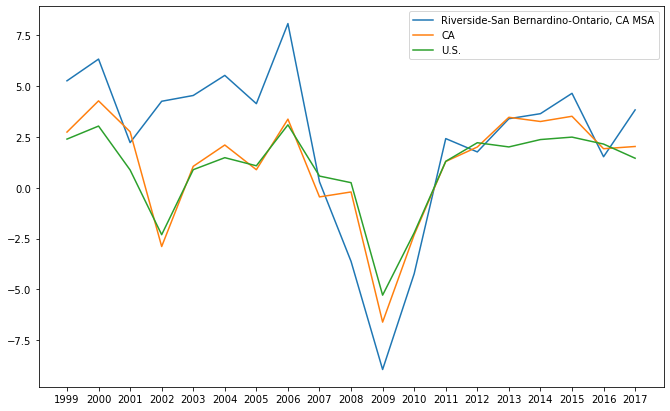

In [16]:
#MSA = 'Los Angeles-Long Beach-Anaheim, CA MSA'
MSA = 'Riverside-San Bernardino-Ontario, CA MSA'
#MSA = 'San Diego-Chula Vista-Carlsbad, CA MSA'
#MSA = 'Oxnard-Thousand Oaks-Ventura, CA MSA'
#MSA = 'Santa Maria-Santa Barbara, CA MSA'

#MSA = 'Denver-Aurora-Lakewood, CO MSA'
NAICS_code = '--'

plt.figure()

fsize = 7
plt.gcf().set_size_inches(fsize*1.6,fsize)

tot_empl_ppc[ (MSA,NAICS_code) ].plot(label=MSA)
tot_empl_state_ppc[ ( abbr_to_state_dict[MSA_to_state_dict[MSA]] ,NAICS_code) ].plot(label=MSA_to_state_dict[MSA])
tot_empl_state_ppc[ ( 'United States' ,NAICS_code) ].plot(label='U.S.')

ax = plt.gca()
ax.set_yticks( [0], minor=True )
ax.yaxis.grid(True, which='minor')

plt.legend()
plt.xticks(list(range(year_start+1,year_end) ));
#plt.grid(True)

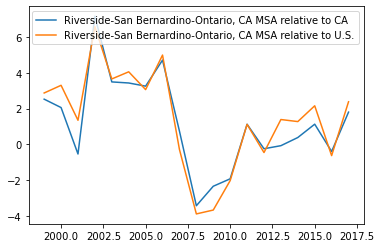

In [17]:
ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
ppc_relative_state.plot(label=MSA+' relative to '+MSA_to_state_dict[MSA])
ppc_relative_country.plot(label=MSA+' relative to U.S.')
plt.legend()

# Correlation with house data
- ## Read, clean and Calculate PPC

In [122]:
house_df = pd.read_csv('data/other-data/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv')
del house_df['RegionID'], house_df['SizeRank'], house_df['RegionType'], house_df['StateName']
house_df.set_index('RegionName',drop=True,inplace=True)
house_df = house_df.T
house_df.index = pd.to_datetime(house_df.index)

house_df = house_df.rolling(12,center=True).mean()

house_df['Year'] = house_df.index.year
house_df = house_df.groupby(house_df['Year']).mean()
house_df = house_df.loc[ list( range(year_start,2020) ) ]

# calculate PPC
window_size = 2
house_ppc_df = house_df.diff()/house_df.shift()*100
house_ppc_df = house_ppc_df.rolling(window=window_size,center=False).mean().drop( house_ppc_df.index[:window_size-1] )
house_ppc_df = house_ppc_df.drop( house_ppc_df.index[0] )

- ## Some more utilities

In [45]:
def house_ppc_relative(MSA_rank):
    return house_ppc_df[house_ppc_df.columns[MSA_rank]]-house_ppc_df[house_ppc_df.columns[0]]

In [46]:
houseRank_to_empRank = {1:None, 2:0, 3:1, 4:2, 5:4, 6:5, 7:3, 8:8, 9:7,
                        10:6, 11:9, 12:None, 13:17, 14:12, 15:11, 16:10, 17:14, 18:15, 19:18 ,
                        20:16, 21:13, 22:19, 23:None, 24:22, 25:31, 26:26, 27:20, 28:24, 29:None, 30:23 }

In [47]:
def available_industries(MSA):
    code_list = list(tot_empl_all[MSA].columns)
    return pd.Series( [ NAICS_dict[ key ] for key in code_list ] , index=code_list )

def print_info(house_rank):
    print( "MSA: ", house_ppc_df.columns[ house_rank ] )
    if houseRank_to_empRank[house_rank] != None: 
        print( "Available Industires:\n", available_industries( msa_emp_rank_df_dict[ houseRank_to_empRank[house_rank] ] ) )
    else:
        print("Employment data no available at the moment")

- ## Compare PPC

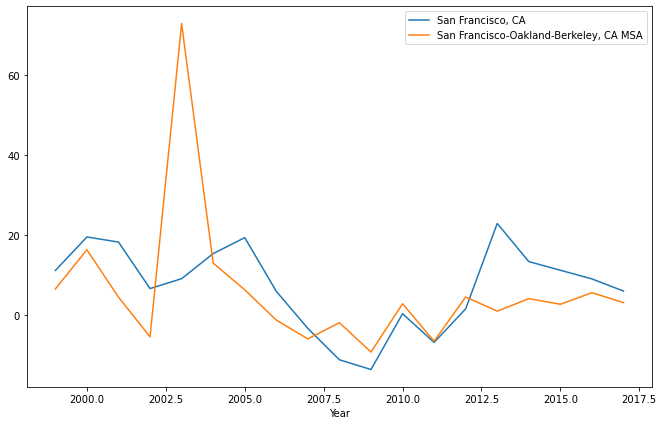

In [21]:
plt.figure()

fsize = 7
plt.gcf().set_size_inches(fsize*1.6,fsize)


MSA_rank = 11
house_ppc_df[house_ppc_df.columns[MSA_rank]].plot( label= house_ppc_df.columns[MSA_rank])


MSA_rank = houseRank_to_empRank[MSA_rank]
MSA = msa_emp_rank_df_dict[MSA_rank]
NAICS_code = '54'

tot_empl_ppc[ (MSA,NAICS_code) ].plot(label=MSA)

plt.legend()
#plt.ylim( (-10,10) )

- ## Compare Relative PPC

In [80]:
MSA_rank = 2
print_info(MSA_rank)

MSA:  Los Angeles-Long Beach-Anaheim, CA
Available Industires:
 --                                                   Total
11              Agriculture, Forestry, Fishing and Hunting
21           Mining, Quarrying, and Oil and Gas Extraction
22                                               Utilities
23                                            Construction
31-33                                        Manufacturing
42                                         Wholesale Trade
44-45                                         Retail Trade
48-49                       Transportation and Warehousing
51                                             Information
52                                   Finance and Insurance
53                      Real Estate and Rental and Leasing
54        Professional, Scientific, and Technical Services
55                 Management of Companies and Enterprises
56       Administrative and Support and Waste Managemen...
61                                    Educational S

Text(0, 0.5, 'Relative Percent Point Difference')

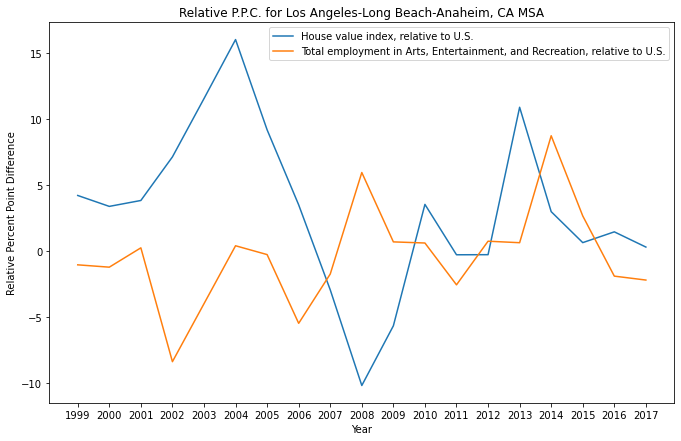

In [92]:
plt.figure()

fsize = 7
plt.gcf().set_size_inches(fsize*1.6,fsize)


#MSA_rank = 6
house_ppc_relative(MSA_rank).plot( label= 'House value index, relative to U.S.' ) #house_ppc_df.columns[MSA_rank]


MSA_emp_rank = houseRank_to_empRank[MSA_rank]
MSA = msa_emp_rank_df_dict[MSA_emp_rank]
NAICS_code = '71'
ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
#ppc_relative_state.plot(label=MSA+' relative to '+MSA_to_state_dict[MSA])
#ppc_relative_country.drop
ppc_relative_country.drop([2003]).plot(label="Total employment in "+NAICS_dict[NAICS_code]+ ', relative to U.S.' )

plt.legend()
#plt.ylim( (-10,10) )

plt.legend()
plt.xticks(list(range(year_start+1,year_end) ));
plt.title( "Relative P.P.C. for "+MSA )
plt.xlabel("Year")
plt.ylabel("Relative Percent Point Difference")

## Correlation with poverty and income data

- ## Read and calculate PPC

In [123]:
poverty_df = pd.read_csv( 'data/saipe/poverty_percent_county_years_.csv',header=[0,1] ,index_col=0)
income_df = pd.read_csv('data/saipe/income_county_years_.csv',header=[0,1],index_col=0)

window_size = 2

poverty_df.dropna(axis=1,inplace=True)
poverty_ppc_df = poverty_df.pct_change()*100
poverty_ppc_df = poverty_ppc_df.drop( poverty_ppc_df.index[0] )
poverty_ppc_df = poverty_ppc_df.rolling(window=window_size,center=False).mean().drop( poverty_ppc_df.index[:window_size-1] )

income_df.dropna(axis=1,inplace=True)
income_ppc_df = income_df.pct_change()*100
income_ppc_df = income_ppc_df.drop( income_ppc_df.index[0] )
income_ppc_df = income_ppc_df.rolling(window=window_size,center=False).mean().drop( income_ppc_df.index[:window_size-1] )

In [42]:
def relative_ppc_poverty(MSA_rank):
    return -poverty_ppc_df[ houseRank_to_county[MSA_rank] ] + poverty_ppc_df['US','United States']

def relative_ppc_income(MSA_rank):
    return income_ppc_df[ houseRank_to_county[MSA_rank] ] - income_ppc_df['US','United States']

In [48]:
houseRank_to_county = {1:('US','United States'), 2:('CA','Los Angeles County'), 3:('IL','Cook County'), 4:('TX','Dallas County'), 5:('PA',''), 
                       6:('TX','Harris County'), 7:('DC','District of Columbia'), 8:('FL','Miami-Dade County'), 9:('GA','Fulton County'), 10:('MA','Suffolk County'), 
                       11:('CA','San Francisco County'), 12:('MI','Wayne County'), 13:('CA','Riverside County'), 14:('AZ','Maricopa County'), 15:('WA','King County'), 
                       16:('',''), 17:('CA','San Diego County'), 18:('',''), 19:('','') ,  20:16, 
                       21:13, 22:19, 23:'NaN', 24:22, 25:('CA','Sacramento County')
                        }

- ## Plots

In [144]:
MSA_rank = 13
MSA = msa_emp_rank_df_dict[ houseRank_to_empRank[MSA_rank] ]
print_info(MSA_rank)

MSA:  Riverside, CA
Available Industires:
 --                                                   Total
21           Mining, Quarrying, and Oil and Gas Extraction
22                                               Utilities
23                                            Construction
31-33                                        Manufacturing
42                                         Wholesale Trade
44-45                                         Retail Trade
48-49                       Transportation and Warehousing
51                                             Information
52                                   Finance and Insurance
53                      Real Estate and Rental and Leasing
54        Professional, Scientific, and Technical Services
55                 Management of Companies and Enterprises
56       Administrative and Support and Waste Managemen...
61                                    Educational Services
62                       Health Care and Social Assistance
71           

In [142]:

#NAICS_code = '--'
#ppc_relative_country = ppc_relative_country.drop([2004]).drop([2003])

def plot_emp_HIP(MSA_rank, NAICS_code,MSA_str):
    ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
    
    fig = plt.figure()
    fsize = 12
    plt.gcf().set_size_inches(fsize*1.6,fsize)
    year_min = 1999
    year_max = 2018

    #plt.subplots(31)
    #fig.suptitle( "Relative Point Percent Difference for "+MSA ,fontsize='xx-large' )
    fig.suptitle( "Effect of employment on housing, poverty and income, for "+MSA ,fontsize='xx-large' )

    plt.subplot(311)
    ppc_relative_country.plot(label="Total employment in "+NAICS_dict[NAICS_code]+ ', relative to U.S.' ,c='navy')
    house_ppc_relative(MSA_rank).plot( label= 'House value index, relative to U.S.' ,color='limegreen') #house_ppc_df.columns[MSA_rank]
    plt.plot( [year_min,year_max],[0,0],color='grey',lw=0.5 )
    plt.xlim( [year_min,year_max] )
    plt.xticks( list(range(year_min,year_max+1) ));
    plt.legend()
    #plt.title( "Relative P.P.C. for "+MSA )

    plt.subplot(312)
    ppc_relative_country.plot(label="Total employment in "+NAICS_dict[NAICS_code]+ ', relative to U.S.',c='navy' )
    relative_ppc_poverty(MSA_rank).plot(label='Poverty'+ ', relative to U.S.',color='indianred')
    plt.plot( [year_min,year_max],[0,0],color='grey',lw=0.5 )
    plt.xlim( [year_min,year_max] )
    plt.xticks( list(range(year_min,year_max+1) ));
    plt.legend()
    plt.ylabel("Relative Percent Point Difference",fontsize='xx-large')

    plt.subplot(313)
    ppc_relative_country.plot(label="Total employment in "+NAICS_dict[NAICS_code]+ ', relative to U.S.' ,c='navy')
    relative_ppc_income(MSA_rank).plot(label='Income'+ ', relative to U.S.',color='cyan' )
    plt.plot( [year_min,year_max],[0,0],color='grey',lw=0.5 )
    plt.xlim( [year_min,year_max] )
    #plt.ylim( (-10,10) )
    plt.xticks( list(range(year_min,year_max+1) ));
    plt.legend()

    plt.xlabel("Year",fontsize='x-large')

    #plt.ylabel("Relative Percent Point Difference")
    plt.savefig('data/plots/empl_RA_Hv2PI_'+ NAICS_dict[NAICS_code][:4] +'_'+MSA_str+'.png')
    plt.close()
    
#[ '--','23','42','44-45','51','52','53','54','62','71','72' ]
for NAICS_code in [ '--','11', '23','31-33','42','44-45','48-49','51','52','53','54','62','71','72' ]:
    if NAICS_code in list(tot_empl_all[MSA].columns):
        plot_emp_HIP( MSA_rank,NAICS_code,'Riverside' )

# Draft

In [124]:
#tot_empl_state_all['Wyoming']
#tot_empl_state_all['California']
#tot_empl_state_all['Alabama']
#tot_empl_state_all

In [123]:
#tot_empl_all[MSA]

In [125]:
#msa_emp_rank_df.iloc[:35]

In [126]:
houseRank_to_empRank = {1:'NaN', 2:0, 3:1, 4:2, 5:4, 6:5, 7:3, 8:8, 9:7,
                        10:6, 11:9, 12:'NaN', 13:17, 14:12, 15:11, 16:10, 17:14, 18:15, 19:18 ,
                        20:16, 21:13, 22:19, 23:'NaN', 24:22, 25:31, 26:26, 27:20, 28:24, 29:'NaN', 30:23 }
pd.DataFrame(house_ppc_df.columns[:35])

,RegionName
0,United States
1,"New York, NY"
2,"Los Angeles-Long Beach-Anaheim, CA"
3,"Chicago, IL"
4,"Dallas-Fort Worth, TX"
5,"Philadelphia, PA"
6,"Houston, TX"
7,"Washington, DC"
8,"Miami-Fort Lauderdale, FL"
9,"Atlanta, GA"


In [157]:
houseRank_to_county = {1:('US','United States'), 2:('CA','Los Angeles County'), 3:('IL','Cook County'), 4:('TX','Dallas County'), 5:('PA',''), 
                       6:('TX','Harris County'), 7:('DC','District of Columbia'), 8:('FL','Miami-Dade County'), 9:('GA','Fulton County'), 10:('MA','Suffolk County'), 
                       11:('CA','San Francisco County'), 12:('MI','Wayne County'), 13:('CA','Riverside County'), 14:('AZ','Maricopa County'), 15:('WA','King County'), 
                       16:('',''), 17:('CA','San Diego County'), 18:('',''), 19:('FL','Hillsborough County') ,  20:('MD','Baltimore city'), 
                       21:('CO','Denver County'), 22:('PA','Allegheny County'), 23:'NaN', 24:22, 25:('CA','Sacramento County'),
                       26:('TX','Bexar County'), 27:('FL','Orange County')
                        }

In [156]:
poverty_ppc_df['FL'].columns[:]

Index(['Florida', 'Alachua County', 'Baker County', 'Bay County',
       'Bradford County', 'Brevard County', 'Broward County', 'Calhoun County',
       'Charlotte County', 'Citrus County', 'Clay County', 'Collier County',
       'Columbia County', 'DeSoto County', 'Dixie County', 'Duval County',
       'Escambia County', 'Flagler County', 'Franklin County',
       'Gadsden County', 'Gilchrist County', 'Glades County', 'Gulf County',
       'Hamilton County', 'Hardee County', 'Hendry County', 'Hernando County',
       'Highlands County', 'Hillsborough County', 'Holmes County',
       'Indian River County', 'Jackson County', 'Jefferson County',
       'Lafayette County', 'Lake County', 'Lee County', 'Leon County',
       'Levy County', 'Liberty County', 'Madison County', 'Manatee County',
       'Marion County', 'Martin County', 'Miami-Dade County', 'Monroe County',
       'Nassau County', 'Okaloosa County', 'Okeechobee County',
       'Orange County', 'Osceola County', 'Palm Beach Coun

In [9]:
#poverty_df['US'].rolling(3,center=True).mean().dropna()
len(poverty_df.columns)

3184

In [7]:
len(df_2017['MSA'].unique())

351

In [56]:
tot_empl_all#.rolling(2).mean()

MSA        Abilene, TX MSA                                                   \
NAICS Code              --      21      23   31-33   44-45      52       62   
1998               48503.0  1042.0  2396.0  3462.0  7342.0  1877.0   9720.0   
1999               48514.0   491.0  2300.0  3702.0  7339.0  1893.0  10145.0   
2000               49157.0   635.0  2506.0  3706.0  7230.0  2436.0  10176.0   
2001               48664.0   693.0  2316.0  3281.0  7489.0  2429.0  10033.0   
2002               49969.0   834.0  3002.0  3177.0  7633.0  2648.0   9756.0   
2003               57108.0   875.0  3670.0  3487.0  8472.0  2909.0  12808.0   
2004               55427.0   931.0  2537.0  2918.0  8634.0  3058.0  12205.0   
2005               53961.0  1038.0  2909.0  2792.0  8586.0  2970.0  11505.0   
2006               55895.0  1141.0  3337.0  2948.0  8820.0  2986.0  12067.0   
2007               56735.0  1476.0  4081.0  2713.0  8977.0  3032.0  12108.0   
2008               58308.0  2642.0  3884.0  2749.0  9109.0  3132.0  11777.0   
2009               56559.0  1194.0  4320.0  2371.0  8746.0  3153.0  11867.0   
2010               55831.0  1410.0  4294.0  2210.0  8424.0  3072.0  12222.0   
2011               55193.0  1640.0  3111.0  2295.0  8535.0  2962.0  12137.0   
2012               57474.0  2184.0  2992.0  2514.0  8470.0  3024.0  13050.0   
2013               57895.0  2044.0  3004.0  2664.0  8860.0  2922.0  12334.0   
2014               57611.0  2214.0  2996.0  2436.0  8835.0  2946.0  12194.0   
2015               59998.0  1825.0  4415.0  2903.0  8764.0  2668.0  13052.0   
2016               59299.0   960.0  4041.0  2840.0  8977.0  2601.0  13053.0   
2017               58400.0  1026.0  3478.0  2874.0  8637.0  2584.0  12948.0   

MSA                Akron, OH MSA           ... Yuba City, CA MSA          \
NAICS Code      81            --       23  ...                62      72   
1998        3181.0      287987.0  15731.0  ...            5439.0  2533.0   
1999        3114.0      290061.0  13455.0  ...            5036.0  2430.0   
2000        3027.0      302159.0  17628.0  ...            4741.0  2320.0   
2001        3091.0      298645.0  17343.0  ...            4750.0  2616.0   
2002        3261.0      289151.0  13648.0  ...            5031.0  3085.0   
2003        3585.0      299324.0  17862.0  ...            4746.0  3221.0   
2004        3568.0      297491.0  17615.0  ...            5012.0  3185.0   
2005        3490.0      297757.0  14156.0  ...            5089.0  3338.0   
2006        3250.0      297342.0  14704.0  ...            5401.0  3441.0   
2007        3118.0      296117.0  14556.0  ...            5628.0  3611.0   
2008        3124.0      292698.0  14225.0  ...            5728.0  3798.0   
2009        2902.0      277143.0  11874.0  ...            6336.0  3297.0   
2010        2961.0      270260.0  11935.0  ...            6329.0  3254.0   
2011        2890.0      277410.0  12295.0  ...            5409.0  3424.0   
2012        3102.0      284198.0  11303.0  ...            5283.0  3345.0   
2013        3033.0      285016.0  10871.0  ...            5663.0  3379.0   
2014        2981.0      291083.0  11529.0  ...            5768.0  3605.0   
2015        3071.0      294127.0  12124.0  ...            5829.0  3559.0   
2016        3259.0      298043.0  13426.0  ...            6193.0  3657.0   
2017        3251.0      296361.0  11749.0  ...            6195.0  3467.0   

MSA                Yuma, AZ MSA                                          \
NAICS Code      81           --      23   31-33      42   44-45      52   
1998        1612.0      30497.0  2571.0  3082.0  1872.0  6308.0   934.0   
1999        1592.0      31256.0  2959.0  2164.0  1682.0  6476.0   964.0   
2000        1627.0      31233.0  2888.0  2321.0  1626.0  6681.0   951.0   
2001        1440.0      32820.0  2858.0  2317.0  1814.0  7076.0   970.0   
2002        1496.0      36268.0  3192.0  2856.0  3686.0  6558.0   859.0   
2003        1505.0      36082.0  3416.0  3111.0  1880.0  6675.0

In [21]:
tot_empl_ppc.loc[2003] = (tot_empl_ppc.loc[2002]+tot_empl_ppc.loc[2004])

In [75]:
#tot_empl_ppc#.rolling(2).mean()
tot_empl_ppc['Abilene, TX MSA'].rolling(2).map(lambda x: x )

AttributeError: 'Rolling' object has no attribute 'map'

In [88]:
poverty_ppc_df

Postal Code            US        AL                                \
Name        United States   Alabama Autauga County Baldwin County   
2000            -5.277045 -3.389831      -3.768116      -4.294479   
2001            -2.785515  0.000000      -1.506024       0.320513   
2002             0.573066  0.219298      -3.363914       0.638978   
2003             3.418803  1.531729      -0.316456       1.269841   
2004             2.754821  0.862069       2.539683      -3.448276   
2005             3.217158  3.205128       0.309598       2.272727   
2006             2.077922  2.691511       6.481481       2.857143   
2007             0.763359  1.008065      -3.478261       0.925926   
2008            -0.252525 -1.996008       0.900901      -4.587156   
2009             2.531646  1.832994      -3.869048       7.371795   
2010             5.679012  4.600000       4.643963       8.955224   
2011             6.308411  6.118547      12.426036       9.589041   
2012             3.516484  2.702703       3.947368       1.500000   
2013             1.061571  0.000000       4.050633       2.216749   
2014            -0.840336  0.175439      -4.379562      -0.963855   
2015            -2.542373 -0.875657       0.000000      -2.433090   
2016            -3.913043 -3.003534       0.000000      -6.234414   
2017            -4.751131 -4.189435       0.763359      -7.712766   
2018            -3.800475 -3.231939       2.777778      -8.933718   
2019            -4.197531 -3.143418      -3.439803      -5.063291   

Postal Code                                                          \
Name        Barbour County Bibb County Blount County Bullock County   
2000             -2.325581    0.778210     -3.376623      -0.715990   
2001              2.232143    2.509653      1.881720       5.889423   
2002              1.892285    1.129944      0.791557       5.448354   
2003              0.000000   -1.862197     -0.261780      -2.260495   
2004             -0.428571   -2.087287     -3.149606      -2.863436   
2005             -1.721664   -2.131783     -3.252033       7.709751   
2006              9.489051    3.960396      2.521008       6.736842   
2007              2.933333    2.095238      1.912568       3.648915   
2008              2.720207    3.544776      4.557641      -4.376784   
2009              5.170240   -1.261261      4.615385       1.791045   
2010             -0.959233    4.927007      8.333333      -2.834800   
2011              6.053269    6.434783      4.072398      -0.804829   
2012             -4.337900    5.555556      3.478261      -2.434077   
2013              3.460621    3.405573      1.470588       4.261954   
2014             -4.728950   -6.137725      5.383023       2.293121   
2015              3.631961    1.116427     -2.946955       7.115010   
2016              1.985981   -4.731861     -6.275304      -2.365787   
2017              9.163803    3.476821    -10.151188      -0.652377   
2018             -1.154250   -0.640000     -3.605769       2.720450   
2019             -2.972399    0.322061      5.486284      -2.374429   

Postal Code                               ...              WY              \
Name        Butler County Calhoun County  ... Niobrara County Park County   
2000            -3.930131      -2.263374  ...       -6.066536   -4.324324   
2001            -2.727273       0.421053  ...       -5.625000   -2.259887   
2002            -2.336449      -1.048218  ...       -2.207506   -2.312139   
2003            -1.116427       2.754237  ...       -1.354402    1.775148   
2004            -0.967742       1.237113  ...       -3.890160   -2.906977   
2005             4.397394       2.240326  ...       -4.523810   -2.994012   
2006             4.368175       2.390438  ...       -2.493766   -4.320988   
2007             3.288490       0.389105  ...       -0.767263    3.548387   
2008            -1.157742       1.356589  ...       -1.288660    0.623053   
2009             9.663250       2.676864  ...        3.394256    0.3095